<a href="https://colab.research.google.com/github/andressriosg/Mineria-de-datos/blob/main/Copia_de_MODELO_COVID19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> STOCHASTIC MODELING, ANALYSIS, AND SIMULATION OF THE COVID-19 PANDEMIC WITH EXPLICIT BEHAVIORAL CHANGES IN BOGOTA: A CASE STUDY </center></h1>

# LIBRERIAS

In [ ]:
#@title
import pandas as pd
import numpy as np
import seaborn as sns
import math 
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize
from numpy import zeros, linspace
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# DATOS

Descargar base de datos del INS del 6 de marzo hasta el 1 de noviembre del 2020

In [ ]:
url = 'https://www.ins.gov.co/BoletinesCasosCOVID19Colombia/2020-11-01.csv'
DATACOVID19_COLOMBIA_FULL = pd.read_csv(url, header=0, encoding="latin2", sep=';', low_memory=False)

## Limpieza de datos

Organizar los nombres de la base de datos

In [ ]:
DATACOVID19_COLOMBIA_FULL.columns = ["Fecha reporte","ID","Fecha notificacion","Codigo departamento",
                                     "Nombre departamento","Codigo ciudad","Nombre ciudad",
                                     "Edad","Unidad medida","Sexo","Contagio","Ubicacion","Estado",
                                     "Codigo ISO pais","Nombre pais","Recuperado","Fecha inicio sintomas",
                                     "Fecha muerte","Fecha diagnostico","Fecha recuperado","Tipo recuperacion",
                                     "Pertenencia etnica","Nombre grupo etnico"]
DATACOVID19_COLOMBIA_FULL.head(3)

,Fecha reporte,ID,Fecha notificacion,Codigo departamento,Nombre departamento,Codigo ciudad,Nombre ciudad,Edad,Unidad medida,Sexo,Contagio,Ubicacion,Estado,Codigo ISO pais,Nombre pais,Recuperado,Fecha inicio sintomas,Fecha muerte,Fecha diagnostico,Fecha recuperado,Tipo recuperacion,Pertenencia etnica,Nombre grupo etnico
0,6/3/2020 0:00:00,1,2/3/2020 0:00:00,11,BOGOTA,11001,BOGOTA,19,1,F,Importado,Casa,Leve,380,ITALIA,Recuperado,27/2/2020 0:00:00,NaN,6/3/2020 0:00:00,13/3/2020 0:00:00,PCR,6.0,NaN
1,9/3/2020 0:00:00,2,6/3/2020 0:00:00,76,VALLE,76111,BUGA,34,1,M,Importado,Casa,Leve,724,ESPAŃA,Recuperado,4/3/2020 0:00:00,NaN,9/3/2020 0:00:00,19/3/2020 0:00:00,PCR,5.0,NaN
2,9/3/2020 0:00:00,3,7/3/2020 0:00:00,5,ANTIOQUIA,5001,MEDELLIN,50,1,F,Importado,Casa,Leve,724,ESPAŃA,Recuperado,29/2/2020 0:00:00,NaN,9/3/2020 0:00:00,15/3/2020 0:00:00,PCR,6.0,NaN


Seleccionar las variables necesarias para el analisis

In [ ]:
colnew_data = ["Fecha reporte","Fecha notificacion","Fecha inicio sintomas",
               "Fecha muerte","Fecha diagnostico","Fecha recuperado", 
               "Recuperado","Contagio","Nombre departamento","Nombre ciudad","Sexo","Edad"]     
DATACOVID19_COLOMBIA = DATACOVID19_COLOMBIA_FULL[colnew_data]                                             

Breve informacion de las variables categorias

In [ ]:
print("Recuperado:\n\n",DATACOVID19_COLOMBIA['Recuperado'].unique(),'\n')
print("Tipo de contagio:\n\n",DATACOVID19_COLOMBIA['Contagio'].unique(),'\n')
print("Sexo:\n\n",DATACOVID19_COLOMBIA["Sexo"].unique(),'\n')

Recuperado:

 ['Recuperado' 'Fallecido' nan 'fallecido'] 

Tipo de contagio:

 ['Importado' 'Relacionado' 'En estudio' 'relacionado' 'RELACIONADO'
 'En Estudio' 'EN ESTUDIO' 'En estudio '] 

Sexo:

 ['F' 'M' 'm' 'f'] 



Limpiezan de las variables categoricas

In [ ]:
DATACOVID19_COLOMBIA = DATACOVID19_COLOMBIA.assign(Recuperado = DATACOVID19_COLOMBIA["Recuperado"].str.capitalize().str.lstrip().str.rstrip())
DATACOVID19_COLOMBIA = DATACOVID19_COLOMBIA.assign(Contagio = DATACOVID19_COLOMBIA["Contagio"].str.capitalize().str.lstrip().str.rstrip())
DATACOVID19_COLOMBIA = DATACOVID19_COLOMBIA.assign(Sexo = DATACOVID19_COLOMBIA["Sexo"].str.capitalize().str.lstrip().str.rstrip())

Breve informacion de las variables categorias luego de las modificaciones

In [ ]:
print("Recuperado:\n\n",DATACOVID19_COLOMBIA["Recuperado"].unique(),'\n')
print("Tipo de contagio:\n\n",DATACOVID19_COLOMBIA["Contagio"].unique(),'\n')
print("Sexo:\n\n",DATACOVID19_COLOMBIA["Sexo"].unique(),'\n')

Recuperado:

 ['Recuperado' 'Fallecido' nan] 

Tipo de contagio:

 ['Importado' 'Relacionado' 'En estudio'] 

Sexo:

 ['F' 'M'] 



Limpieza de las variables de fechas/temporales

In [ ]:
DATACOVID19_COLOMBIA_TIME = DATACOVID19_COLOMBIA.copy() 
DATACOVID19_COLOMBIA_TIME.iloc[:,0:6] = DATACOVID19_COLOMBIA.iloc[:,0:6].apply(lambda x: x.astype(str).str.replace(" 0:00:00",""))
DATACOVID19_BOGOTA_TIME = DATACOVID19_COLOMBIA_TIME[DATACOVID19_COLOMBIA_TIME['Nombre departamento'] == 'BOGOTA']

Ordenar y se filtra la base de acuerdo al estado del caso

In [ ]:
DATACOVID19_BOG_TIME_NI = pd.DataFrame(DATACOVID19_BOGOTA_TIME[DATACOVID19_BOGOTA_TIME['Fecha reporte'] != 'nan']['Fecha reporte'])
DATACOVID19_BOG_TIME_NR = pd.DataFrame(DATACOVID19_BOGOTA_TIME[DATACOVID19_BOGOTA_TIME['Fecha recuperado'] != 'nan']['Fecha recuperado'])
DATACOVID19_BOG_TIME_ND = pd.DataFrame(DATACOVID19_BOGOTA_TIME[np.logical_and(DATACOVID19_BOGOTA_TIME['Fecha muerte'] != 'nan', DATACOVID19_BOGOTA_TIME['Recuperado'] == 'Fallecido')]['Fecha muerte'])

Se modifican las variables temporales al formato indicado

In [ ]:
DATACOVID19_BOG_TIME_NI = DATACOVID19_BOG_TIME_NI.apply(lambda x: pd.to_datetime(x,errors = 'coerce', dayfirst=True))
DATACOVID19_BOG_TIME_NR = DATACOVID19_BOG_TIME_NR.apply(lambda x: pd.to_datetime(x,errors = 'coerce', dayfirst=True))
DATACOVID19_BOG_TIME_ND = DATACOVID19_BOG_TIME_ND.apply(lambda x: pd.to_datetime(x,errors = 'coerce', dayfirst=True))

Creacion de las variables de conteo

In [ ]:
DATACOVID19_BOG_TIME_NI = DATACOVID19_BOG_TIME_NI.groupby('Fecha reporte').size().reset_index(name='Count')
DATACOVID19_BOG_TIME_NR = DATACOVID19_BOG_TIME_NR.groupby('Fecha recuperado').size().reset_index(name='Count')
DATACOVID19_BOG_TIME_ND = DATACOVID19_BOG_TIME_ND.groupby('Fecha muerte').size().reset_index(name='Count')

Se renombra las variables para optimizar su uso posteriomente

In [ ]:
DATACOVID19_BOG_TIME_NI.rename(columns={'Fecha de reporte':'Fecha', 'Count':'Nuevos infectados'}, inplace=True) 
DATACOVID19_BOG_TIME_NR.rename(columns={'Fecha recuperado':'Fecha', 'Count':'Nuevos recuperados'}, inplace=True)
DATACOVID19_BOG_TIME_ND.rename(columns={'Fecha muerte':'Fecha', 'Count':'Nuevas muertes'}, inplace=True) 

Creacion de las variables acumulativas 

In [ ]:
DATACOVID19_BOG_TIME_NI = DATACOVID19_BOG_TIME_NI.assign(Infectados_Acumulados = DATACOVID19_BOG_TIME_NI.iloc[:,1].cumsum())
DATACOVID19_BOG_TIME_NR = DATACOVID19_BOG_TIME_NR.assign(Recuperados_Acumulados = DATACOVID19_BOG_TIME_NR.iloc[:,1].cumsum())
DATACOVID19_BOG_TIME_ND = DATACOVID19_BOG_TIME_ND.assign(Muertes_Acumuladas = DATACOVID19_BOG_TIME_ND.iloc[:,1].cumsum())
DATACOVID19_BOG_TIME_NI.rename(columns={'Infectados_Acumulados':'Infectados acumulados'}, inplace=True) 
DATACOVID19_BOG_TIME_NR.rename(columns={'Recuperados_Acumulados':'Recuperados acumulados'}, inplace=True)
DATACOVID19_BOG_TIME_ND.rename(columns={'Muertes_Acumuladas':'Muertes acumuladas'}, inplace=True) 

Creacion la variable dia a partir de las variables fecha/temporales

In [ ]:
DAYS_NI = DATACOVID19_BOG_TIME_NI.iloc[:,0] - DATACOVID19_BOG_TIME_NI.iloc[0,0] 
DAYS_NR = DATACOVID19_BOG_TIME_NR.iloc[:,0] - DATACOVID19_BOG_TIME_NI.iloc[0,0]
DAYS_ND = DATACOVID19_BOG_TIME_ND.iloc[:,0] - DATACOVID19_BOG_TIME_NI.iloc[0,0] 
DATACOVID19_BOG_DAYS_NI = DATACOVID19_BOG_TIME_NI.iloc[:,1:3].assign(Dia = DAYS_NI.apply(lambda x: x.days)) 
DATACOVID19_BOG_DAYS_NR = DATACOVID19_BOG_TIME_NR.iloc[:,1:3].assign(Dia = DAYS_NR.apply(lambda x: x.days)) 
DATACOVID19_BOG_DAYS_ND = DATACOVID19_BOG_TIME_ND.iloc[:,1:3].assign(Dia = DAYS_ND.apply(lambda x: x.days))

## Análisis exploratorio de datos

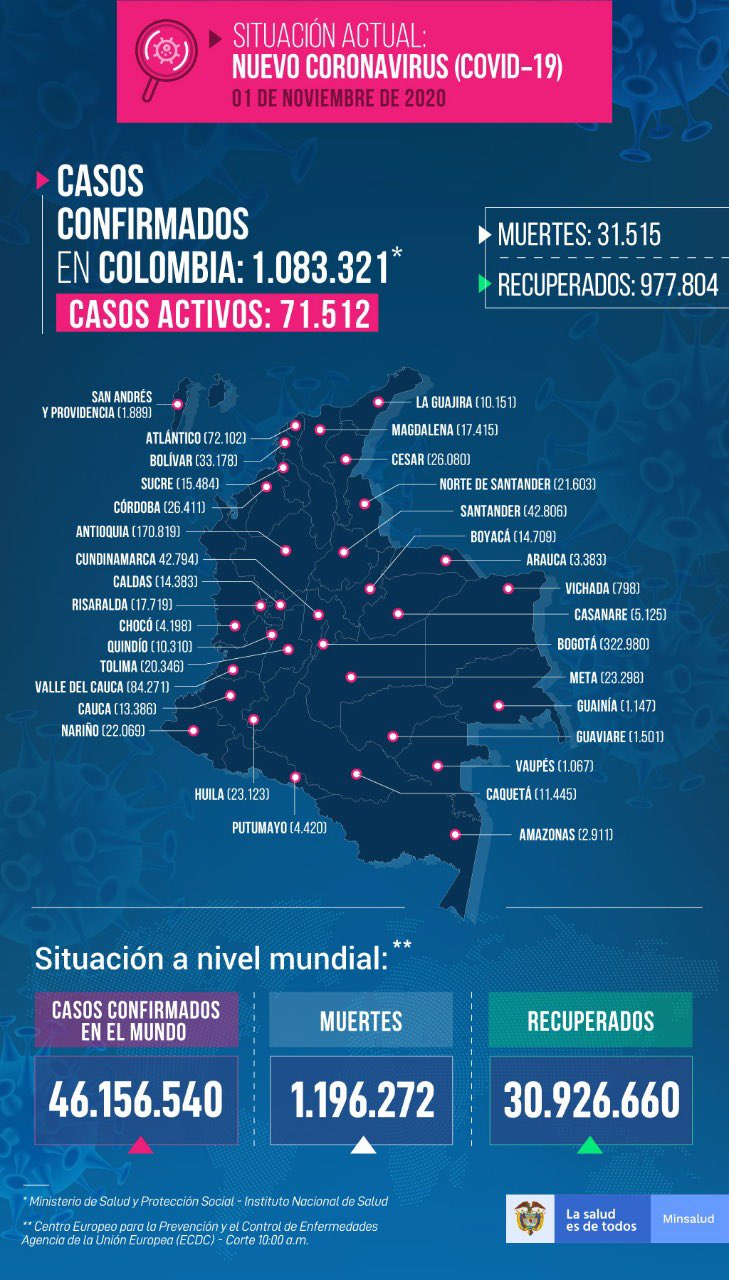

Informacion basica para mirar la consistencia con respecto al reporte del INS oficial

In [ ]:
#@title
print("Informacion basica para Colombia:\n")
print('Casos confirmados:', len(DATACOVID19_COLOMBIA_TIME[DATACOVID19_COLOMBIA_TIME['Fecha reporte'] != 'nan']))
print('Casos notificados:' , len(DATACOVID19_COLOMBIA_TIME[DATACOVID19_COLOMBIA_TIME['Fecha notificacion'] != 'nan']))
print('Casos con sintomas:', len(DATACOVID19_COLOMBIA_TIME[DATACOVID19_COLOMBIA_TIME['Fecha inicio sintomas'] != 'nan']))
print('Casos de muertes:', len(DATACOVID19_COLOMBIA_TIME[np.logical_and(DATACOVID19_COLOMBIA_TIME['Fecha muerte'] != 'nan',
                                                                        DATACOVID19_COLOMBIA_TIME['Recuperado'] == 'Fallecido')]))
print('Casos diagnosticados:', len(DATACOVID19_COLOMBIA_TIME[DATACOVID19_COLOMBIA_TIME['Fecha diagnostico'] != 'nan']))
print('Casos recuperados:', len(DATACOVID19_COLOMBIA_TIME[DATACOVID19_COLOMBIA_TIME['Fecha recuperado'] != 'nan']), '\n \n')

print("Informacion basica para Bogotá:\n")
print('Casos confirmados:', len(DATACOVID19_BOGOTA_TIME[DATACOVID19_BOGOTA_TIME['Fecha reporte'] != 'nan']))
print('Casos notificados:', len(DATACOVID19_BOGOTA_TIME[DATACOVID19_BOGOTA_TIME['Fecha notificacion'] != 'nan']))
print('Casos con sintomas:', len(DATACOVID19_BOGOTA_TIME[DATACOVID19_BOGOTA_TIME['Fecha inicio sintomas'] != 'nan']))
print('Casos de muertes:', len(DATACOVID19_BOGOTA_TIME[np.logical_and(DATACOVID19_BOGOTA_TIME['Fecha muerte'] != 'nan',
                                                                      DATACOVID19_BOGOTA_TIME['Recuperado'] == 'Fallecido')]))
print('Casos diagnosticados:', len(DATACOVID19_BOGOTA_TIME[DATACOVID19_BOGOTA_TIME['Fecha diagnostico'] != 'nan']))
print('Casos recuperados:', len(DATACOVID19_BOGOTA_TIME[DATACOVID19_BOGOTA_TIME['Fecha recuperado'] != 'nan']))

Informacion basica para Colombia:

Casos confirmados: 1083321
Casos notificados: 1083321
Casos con sintomas: 946510
Casos de muertes: 31515
Casos diagnosticados: 1079031
Casos recuperados: 977804 
 

Informacion basica para Bogotá:

Casos confirmados: 322980
Casos notificados: 322980
Casos con sintomas: 196714
Casos de muertes: 7670
Casos diagnosticados: 322754
Casos recuperados: 292242


El analisis del trabajo actual comprende del dia 1, es decir 6 de marzo, hasta el dia 200, el cual es el 22 de septiembre del 2020. Por lo tanto, se realiza el filtrado hasta el dia 200

In [ ]:
DATACOVID19_BOG_DAYS200_NI = DATACOVID19_BOG_DAYS_NI[DATACOVID19_BOG_DAYS_NI['Dia'] <= 200]
DATACOVID19_BOG_DAYS200_NR = DATACOVID19_BOG_DAYS_NR[DATACOVID19_BOG_DAYS_NR['Dia'] <= 200]
DATACOVID19_BOG_DAYS200_ND = DATACOVID19_BOG_DAYS_ND[DATACOVID19_BOG_DAYS_ND['Dia'] <= 200]

### Estadisticas basicas

In [ ]:
print(DATACOVID19_BOG_DAYS200_NI.describe(), '\n')
print(DATACOVID19_BOG_DAYS200_NR.describe(), '\n')
print(DATACOVID19_BOG_DAYS200_ND.describe(), '\n')

       Nuevos infectados  Infectados acumulados         Dia
count         197.000000             197.000000  197.000000
mean         1300.213198           65121.263959  101.979695
std          1419.070253           83781.640668   57.048937
min             1.000000               1.000000    0.000000
25%           112.000000            2390.000000   53.000000
50%           552.000000           16853.000000  102.000000
75%          2174.000000          113841.000000  151.000000
max          6068.000000          256142.000000  200.000000 

       Nuevos recuperados  Recuperados acumulados         Dia
count          188.000000              188.000000  188.000000
mean          1138.063830            42899.111702  106.409574
std           1593.048383            62834.182549   54.572204
min              1.000000                1.000000    7.000000
25%             61.250000             1309.750000   59.750000
50%            372.500000             9367.000000  106.500000
75%           1734.50000

### Graficos descriptivos 

In [ ]:
#@title
class Descriptive_Graphics:
  
  def __init__(self, x, y, name_x = None, name_y = None, label=None, 
               label_aux1=None, label_aux2=None, label_aux3=None):

    self.x = x
    self.y = y
    self.name_x = name_x
    self.name_y = name_y
    self.label = label
    self.label_aux1 = label_aux1
    self.label_aux2 = label_aux2
    self.label_aux3 = label_aux3

  def plot(self):

    max_x = self.x.max()
    max_y = self.y.max() + self.y.max()*0.1
    plt.figure(figsize=(10, 7))
    plt.style.use('seaborn-whitegrid') 
    ax = plt.axes()
    ax.set_xlim(0,max_x)
    ax.set_ylim(0,max_y)
    plt.bar(self.x, self.y, alpha = 0.5, color = '#377EB8', label = self.label)
    plt.axvline(x = 18, linestyle = "--", color = '#E41A1C', label = self.label_aux1)
    plt.axvline(x = 66, linestyle = "--", color = '#0F8554', label = self.label_aux2)
    plt.axvline(x = 179, linestyle = "--", color = '#A65628', label = self.label_aux3)
    plt.xlabel(self.name_x, size = 12, fontfamily = "sans-serif", color = '#3c4142')
    plt.ylabel(self.name_y, size = 12, fontfamily = "sans-serif", color = '#3c4142') 
    plt.legend(loc = 'upper right', bbox_to_anchor=(0.55, 1), fontsize=10)
    plt.gca().spines["top"].set_alpha(0.1)    
    plt.gca().spines["bottom"].set_alpha(0.1)
    plt.gca().spines["right"].set_alpha(0.1)    
    plt.gca().spines["left"].set_alpha(0.1)
    plt.grid(linestyle='-', alpha=0.3)
    plt.show();

Nuevos infectados

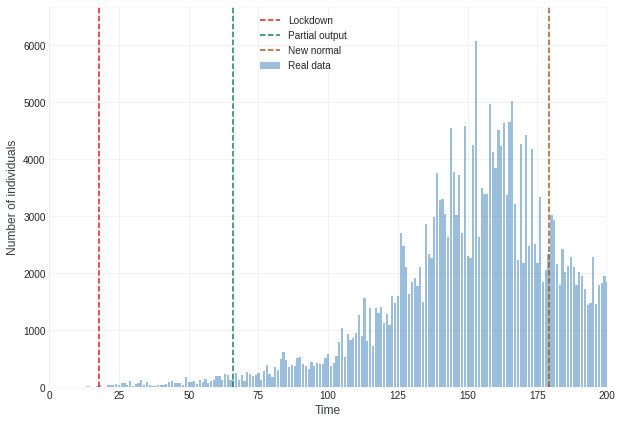

In [ ]:
DG = Descriptive_Graphics(x = DATACOVID19_BOG_DAYS200_NI['Dia'], 
                          y = DATACOVID19_BOG_DAYS200_NI['Nuevos infectados'],
                          name_x = 'Time', 
                          name_y = 'Number of individuals', 
                          label = 'Real data', 
                          label_aux1 = 'Lockdown', 
                          label_aux2 = 'Partial output', 
                          label_aux3 = 'New normal')
DG.plot()

Infectados acumulados

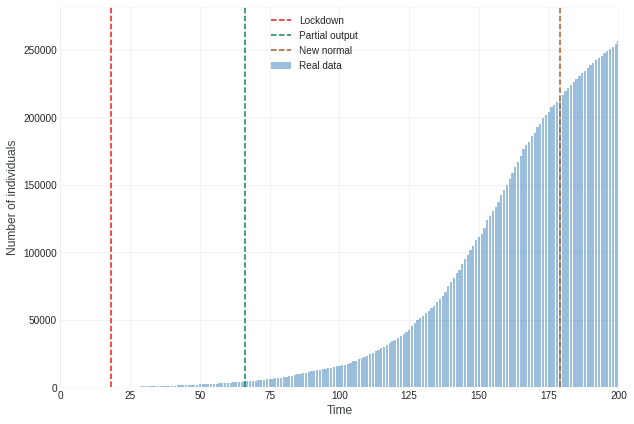

In [ ]:
DG = Descriptive_Graphics(x = DATACOVID19_BOG_DAYS200_NI['Dia'], 
                          y = DATACOVID19_BOG_DAYS200_NI['Infectados acumulados'],
                          name_x = 'Time', 
                          name_y = 'Number of individuals', 
                          label = 'Real data', 
                          label_aux1 = 'Lockdown', 
                          label_aux2 = 'Partial output', 
                          label_aux3 = 'New normal')
DG.plot()

Recuperados acumulados

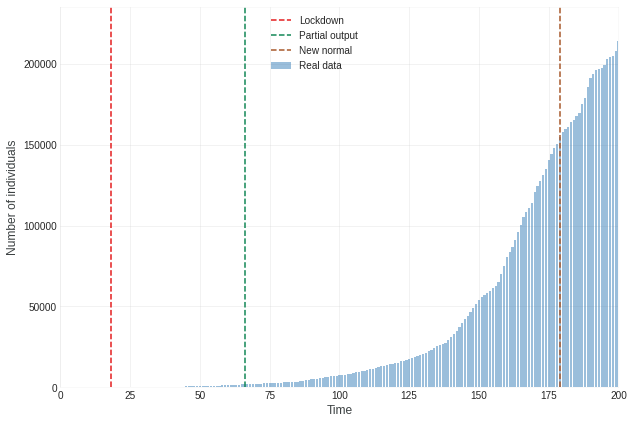

In [ ]:
DG = Descriptive_Graphics(x = DATACOVID19_BOG_DAYS200_NR['Dia'], 
                          y = DATACOVID19_BOG_DAYS200_NR['Recuperados acumulados'],
                          name_x = 'Time', 
                          name_y = 'Number of individuals', 
                          label = 'Real data', 
                          label_aux1 = 'Lockdown', 
                          label_aux2 = 'Partial output', 
                          label_aux3 = 'New normal')
DG.plot()

Muertes acumuladas

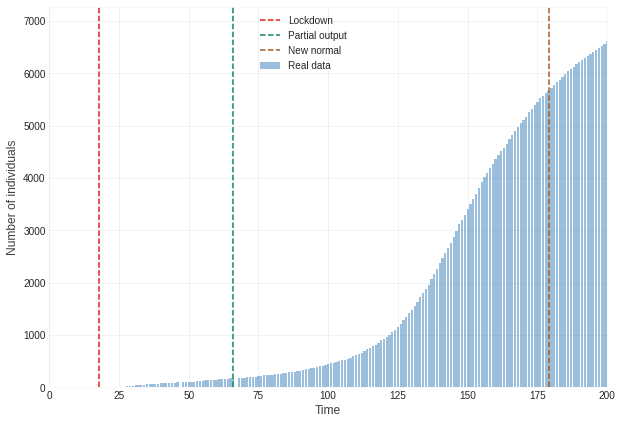

In [ ]:
DG = Descriptive_Graphics(x = DATACOVID19_BOG_DAYS200_ND['Dia'], 
                          y = DATACOVID19_BOG_DAYS200_ND['Muertes acumuladas'],
                          name_x = 'Time', 
                          name_y = 'Number of individuals', 
                          label = 'Real data', 
                          label_aux1 = 'Lockdown', 
                          label_aux2 = 'Partial output', 
                          label_aux3 = 'New normal')
DG.plot()

# AJUSTE DE PARAMETROS

Se ajustan los parametros entre el dia 0 hasta el dia 100. Y se proyectara entre el dia 100 hasta el dia 200

In [ ]:
DATACOVID19_BOG_DAYS_NI_C = DATACOVID19_BOG_DAYS_NI[DATACOVID19_BOG_DAYS_NI['Dia'] <= 100]
DATACOVID19_BOG_DAYS_NR_C = DATACOVID19_BOG_DAYS_NR[DATACOVID19_BOG_DAYS_NR['Dia'] <= 100]
DATACOVID19_BOG_DAYS_ND_C = DATACOVID19_BOG_DAYS_ND[DATACOVID19_BOG_DAYS_ND['Dia'] <= 100]

## Datos infectados

### Modelo SCE2IQHRD para ajuste de parametros 

In [ ]:
class Model_Fit:

  def __init__(self, initial_conditions, x_data, beta, omega, xi, alphaR, alphaD, nu, x):
    
    # initial conditions
    self.initial_conditions = initial_conditions
    self.N = sum(self.initial_conditions)

    # data
    self.x_data = x_data

    # time 
    self.analysis_time = max(self.x_data) # day 65     
    self.dt = 1 # each day 
    self.time = np.arange(0,self.analysis_time+self.dt,self.dt) # vector dim 66 / 0 to 65

    # store parameters
    self.beta = beta
    self.omega = omega
    self.xi = xi
    self.alphaR = alphaR
    self.alphaD = alphaD    
    self.nu = nu
    self.x = x

    # fixed parameters

    self.kappa = 1/4.6
    self.gamma = 1/8
    self.p = 0.1
    self.q = 0.19    
    self.a = 0.934
    self.b = 0.011
    self.t_a = 18
    self.t_b = 66
    self.epsilon = 5

  def structure(self):

    # definition delta
    def delta(n):
      if n == 0:
        return 1
      else:
        return 0   

    # definition beta
    def beta_function(n):
      if n > 0:
        return self.beta*self.epsilon
      else:
        return self.beta

    # compartments
    S = np.zeros(self.analysis_time+1) # vector dim 66 / 0 to 65
    C = np.zeros(self.analysis_time+1)
    E = np.zeros(self.analysis_time+1)
    IA = np.zeros(self.analysis_time+1)
    IS = np.zeros(self.analysis_time+1)
    Q = np.zeros(self.analysis_time+1)
    H = np.zeros(self.analysis_time+1)
    R = np.zeros(self.analysis_time+1)
    D = np.zeros(self.analysis_time+1)

    # initial conditions assigned.
    S[0], C[0], E[0], IA[0], IS[0], Q[0], H[0], R[0], D[0] = self.initial_conditions

    # forward Euler
    dt = self.dt
    for j in self.time[:self.analysis_time]: # j in 0 to 64

      self.phi = self.a*delta(j-self.t_a)
      self.psi = self.b*delta(j-self.t_b)
      S[j+1] = S[j] - (self.phi*S[j] - self.psi*C[j] + beta_function(j-self.t_a)*S[j]*(IA[j]+IS[j])/self.N)*dt
      C[j+1] = C[j] + (self.phi*S[j] - self.psi*C[j])*dt
      E[j+1] = E[j] + (beta_function(j-self.t_a)*S[j]*(IA[j]+IS[j])/self.N - self.kappa*E[j])*dt
      IA[j+1] = IA[j] + ((1-self.p)*self.kappa*E[j] - self.omega*IA[j])*dt
      IS[j+1] = IS[j] + (self.p*self.kappa*E[j] + (1-self.nu)*self.omega*IA[j] - self.xi*IS[j])*dt
      Q[j+1] = Q[j] + (self.xi*IS[j] - self.gamma*Q[j])*dt
      H[j+1] = H[j] + (self.q*self.gamma*Q[j] - ((1-self.x)*self.alphaR + self.x*self.alphaD)*H[j])*dt
      R[j+1] = R[j] + (self.nu*self.omega*IA[j] + (1-self.q)*self.gamma*Q[j] + (1-self.x)*self.alphaR*H[j])*dt
      D[j+1] = D[j] + (self.x*self.alphaD*H[j])*dt

    # data model
    # 'Time':self.time, 'S':S,'E':E,'IA':IA,'IS':IS,
    # 'Q':Q,'H':H,'R':R,'D':D,'CI':CI
    CI = N - (S+C)   
    data_model = pd.DataFrame({'Time':self.time, 'S':S,'E':E,'IA':IA,'IS':IS,'Q':Q,'H':H,'R':R,'D':D,'CI':CI})

    # the data is filtered to do the parameter adjustment
    data_model_filter = pd.DataFrame(np.zeros((0, 0)))
    for i in self.x_data:
      data_model_filter = data_model_filter.append(data_model[data_model['Time'] == i])

    return data_model_filter

### Metodo de minimos cuadrados no lineales

Condiciones iniciales

In [ ]:
N = 7743955
E0 = 6
IA0 = 0
IS0 = 1
Q0 = 0
H0 = 0
R0 = 0
D0 = 0
C0 = 0
S0 = N - C0 - E0 - IA0 - IS0 - Q0 - H0 - R0 - D0
initial_conditions = S0, C0, E0, IA0, IS0, Q0, H0, R0, D0

Informacion para el metodo

In [ ]:
#    beta,    omega,    xi,      alphaR,    alphaD,    nu,      x
L = [   0,    1/10,     1/5,     1/12,      1/14,      0,       0]
R = [   2,    1/2.1,    1,       1/9.5,     1/7.6,     1,       1]
bounds = (L, R)
p0 = [0.8,    1/4,      1/1.5,     1/10,      1/10,      0.2,     0.7]

Funcion optimize / Trust Region Reflective para mínimos cuadrados no lineales

In [ ]:
def curve_fit_model(x_data, beta, omega, xi, alphaR, alphaD, nu, x):
    return Model_Fit(initial_conditions, x_data, beta, omega, xi, alphaR, alphaD, nu, x).structure().iloc[:,9]

popt, pcov = optimize.curve_fit(curve_fit_model, DATACOVID19_BOG_DAYS_NI_C['Dia'], DATACOVID19_BOG_DAYS_NI_C['Infectados acumulados'], p0=p0, bounds=bounds)

Parametros ajustados 

In [ ]:
beta, omega, xi, alphaR, alphaD, nu, x = popt
print('beta =', round(beta,6))
print('omega =', round(omega, 6))
print('xi =', round(xi, 6))
print('alphaR =', round(alphaR, 6))
print('alphaD =', round(alphaD, 6))
print('nu =', round(nu, 6))
print('x =', round(x, 6))

beta = 1.063147
omega = 0.47619
xi = 0.2
alphaR = 0.105154
alphaD = 0.1
nu = 0.73112
x = 0.7


In [ ]:
name_parameters = ["beta", "omega", "xi", "alphaR", "alphaD", "nu", "x"]
pstd = np.sqrt(np.diag(pcov))
round(pd.DataFrame({'Parameters':name_parameters, 'Adjustment':popt, 'Standard error':pstd}),6)

,Parameters,Adjustment,Standard error
0,beta,1.063147,2.965016
1,omega,0.476190,13.234271
2,xi,0.200000,1.614248
3,alphaR,0.105154,0.000000
4,alphaD,0.100000,0.000000
5,nu,0.731120,12.446559
6,x,0.700000,0.000000


## Datos recuperados

### Modelo SCE2IQHRD para ajuste de parametros 

In [ ]:
class Model_Fit:

  def __init__(self, initial_conditions, x_data, alphaR, alphaD, x):
    
    # initial conditions
    self.initial_conditions = initial_conditions
    self.N = sum(self.initial_conditions)

    # data
    self.x_data = x_data

    # time 
    self.analysis_time = max(self.x_data) # day 65     
    self.dt = 1 # each day 
    self.time = np.arange(0,self.analysis_time+self.dt,self.dt) # vector dim 66 / 0 to 65

    # store parameters
    self.alphaR = alphaR
    self.alphaD = alphaD
    self.x = x    

    # fixed parameters

    self.beta = 1.063147
    self.omega = 0.47619
    self.xi = 0.2
    self.nu = 0.73112
    self.kappa = 1/4.6
    self.gamma = 1/8
    self.p = 0.1
    self.q = 0.19    
    self.a = 0.934
    self.b = 0.011
    self.t_a = 18
    self.t_b = 66
    self.epsilon = 5

  def structure(self):

    # definition delta
    def delta(n):
      if n == 0:
        return 1
      else:
        return 0   

    # definition beta
    def beta_function(n):
      if n > 0:
        return self.beta*self.epsilon
      else:
        return self.beta

    # compartments
    S = np.zeros(self.analysis_time+1) # vector dim 66 / 0 to 65
    C = np.zeros(self.analysis_time+1)
    E = np.zeros(self.analysis_time+1)
    IA = np.zeros(self.analysis_time+1)
    IS = np.zeros(self.analysis_time+1)
    Q = np.zeros(self.analysis_time+1)
    H = np.zeros(self.analysis_time+1)
    R = np.zeros(self.analysis_time+1)
    D = np.zeros(self.analysis_time+1)

    # initial conditions assigned.
    S[0], C[0], E[0], IA[0], IS[0], Q[0], H[0], R[0], D[0] = self.initial_conditions

    # forward Euler
    dt = self.dt
    for j in self.time[:self.analysis_time]: # j in 0 to 64

      self.phi = self.a*delta(j-self.t_a)
      self.psi = self.b*delta(j-self.t_b)
      S[j+1] = S[j] - (self.phi*S[j] - self.psi*C[j] + beta_function(j-self.t_a)*S[j]*(IA[j]+IS[j])/self.N)*dt
      C[j+1] = C[j] + (self.phi*S[j] - self.psi*C[j])*dt
      E[j+1] = E[j] + (beta_function(j-self.t_a)*S[j]*(IA[j]+IS[j])/self.N - self.kappa*E[j])*dt
      IA[j+1] = IA[j] + ((1-self.p)*self.kappa*E[j] - self.omega*IA[j])*dt
      IS[j+1] = IS[j] + (self.p*self.kappa*E[j] + (1-self.nu)*self.omega*IA[j] - self.xi*IS[j])*dt
      Q[j+1] = Q[j] + (self.xi*IS[j] - self.gamma*Q[j])*dt
      H[j+1] = H[j] + (self.q*self.gamma*Q[j] - ((1-self.x)*self.alphaR + self.x*self.alphaD)*H[j])*dt
      R[j+1] = R[j] + (self.nu*self.omega*IA[j] + (1-self.q)*self.gamma*Q[j] + (1-self.x)*self.alphaR*H[j])*dt
      D[j+1] = D[j] + (self.x*self.alphaD*H[j])*dt

    # data model
    CI = N - (S+C)   
    # 'Time':self.time, 'S':S,'E':E,'IA':IA,'IS':IS,
    # 'Q':Q,'H':H,'R':R,'D':D,'CI':CI    
    data_model = pd.DataFrame({'Time':self.time, 'S':S,'E':E,'IA':IA,'IS':IS,'Q':Q,'H':H,'R':R,'D':D,'CI':CI})

    # the data is filtered to do the parameter adjustment
    data_model_filter = pd.DataFrame(np.zeros((0, 0)))
    for i in self.x_data:
      data_model_filter = data_model_filter.append(data_model[data_model['Time'] == i])

    return data_model_filter

### Metodo de minimos cuadrados no lineales

Condiciones iniciales

In [ ]:
N = 7743955
E0 = 6
IA0 = 0
IS0 = 1
Q0 = 0
H0 = 0
R0 = 0
D0 = 0
C0 = 0
S0 = N - C0 - E0 - IA0 - IS0 - Q0 - H0 - R0 - D0
initial_conditions = S0, C0, E0, IA0, IS0, Q0, H0, R0, D0

Informacion para el metodo

In [ ]:
#    alphaR,   alphaD,   x
L = [1/12,     1/14,     0]
R = [1/9.5,    1/7.6,    1]
bounds = (L, R)
p0 = [1/10,    1/10,   0.8]

Funcion optimize / Trust Region Reflective para mínimos cuadrados no lineales

In [ ]:
def curve_fit_model(x_data, alphaR, alphaD, x):
    return Model_Fit(initial_conditions, x_data, alphaR, alphaD, x).structure().iloc[:,7]

popt, pcov = optimize.curve_fit(curve_fit_model, DATACOVID19_BOG_DAYS_NI_C['Dia'], DATACOVID19_BOG_DAYS_NI_C['Infectados acumulados'], p0=p0, bounds=bounds)

Parametros ajustados 

In [ ]:
alphaR, alphaD, x = popt
print('alphaR =', round(alphaR, 6))
print('alphaD =', round(alphaD, 6))
print('x =', round(x, 6))

alphaR = 0.105263
alphaD = 0.071429
x = 0.0


In [ ]:
name_parameters = ["alphaR", "alphaD", "x"]
pstd = np.sqrt(np.diag(pcov))
round(pd.DataFrame({'Parameters':name_parameters, 'Adjustment':popt, 'Standard error':pstd}),6)

,Parameters,Adjustment,Standard error
0,alphaR,0.105263,6.379961
1,alphaD,0.071429,0.000000
2,x,0.000000,22.652019


## Datos fallecidos

### Modelo SCE2IQHRD para ajuste de parametros 

In [ ]:
class Model_Fit:

  def __init__(self, initial_conditions, x_data, x, alphaD):
    
    # initial conditions
    self.initial_conditions = initial_conditions
    self.N = sum(self.initial_conditions)

    # data
    self.x_data = x_data

    # time 
    self.analysis_time = max(self.x_data) # day 65     
    self.dt = 1 # each day 
    self.time = np.arange(0,self.analysis_time+self.dt,self.dt) # vector dim 66 / 0 to 65

    # store parameters
    self.x = x
    self.alphaD = alphaD

    # fixed parameters
    self.alphaR = 0.105263
    self.beta = 1.063147
    self.omega = 0.47619
    self.xi = 0.2
    self.nu = 0.73112
    self.kappa = 1/4.6
    self.gamma = 1/8
    self.p = 0.1
    self.q = 0.19    
    self.a = 0.934
    self.b = 0.011
    self.t_a = 18
    self.t_b = 66
    self.epsilon = 5

  def structure(self):

    # definition delta
    def delta(n):
      if n == 0:
        return 1
      else:
        return 0   

    # definition beta
    def beta_function(n):
      if n > 0:
        return self.beta*self.epsilon
      else:
        return self.beta

    # compartments
    S = np.zeros(self.analysis_time+1) # vector dim 66 / 0 to 65
    C = np.zeros(self.analysis_time+1)
    E = np.zeros(self.analysis_time+1)
    IA = np.zeros(self.analysis_time+1)
    IS = np.zeros(self.analysis_time+1)
    Q = np.zeros(self.analysis_time+1)
    H = np.zeros(self.analysis_time+1)
    R = np.zeros(self.analysis_time+1)
    D = np.zeros(self.analysis_time+1)

    # initial conditions assigned.
    S[0], C[0], E[0], IA[0], IS[0], Q[0], H[0], R[0], D[0] = self.initial_conditions

    # forward Euler
    dt = self.dt
    for j in self.time[:self.analysis_time]: # j in 0 to 64

      self.phi = self.a*delta(j-self.t_a)
      self.psi = self.b*delta(j-self.t_b)
      S[j+1] = S[j] - (self.phi*S[j] - self.psi*C[j] + beta_function(j-self.t_a)*S[j]*(IA[j]+IS[j])/self.N)*dt
      C[j+1] = C[j] + (self.phi*S[j] - self.psi*C[j])*dt
      E[j+1] = E[j] + (beta_function(j-self.t_a)*S[j]*(IA[j]+IS[j])/self.N - self.kappa*E[j])*dt
      IA[j+1] = IA[j] + ((1-self.p)*self.kappa*E[j] - self.omega*IA[j])*dt
      IS[j+1] = IS[j] + (self.p*self.kappa*E[j] + (1-self.nu)*self.omega*IA[j] - self.xi*IS[j])*dt
      Q[j+1] = Q[j] + (self.xi*IS[j] - self.gamma*Q[j])*dt
      H[j+1] = H[j] + (self.q*self.gamma*Q[j] - ((1-self.x)*self.alphaR + self.x*self.alphaD)*H[j])*dt
      R[j+1] = R[j] + (self.nu*self.omega*IA[j] + (1-self.q)*self.gamma*Q[j] + (1-self.x)*self.alphaR*H[j])*dt
      D[j+1] = D[j] + (self.x*self.alphaD*H[j])*dt

    # data model
    CI = N - (S+C)   
    # 'Time':self.time, 'S':S,'E':E,'IA':IA,'IS':IS,
    # 'Q':Q,'H':H,'R':R,'D':D,'CI':CI    
    data_model = pd.DataFrame({'Time':self.time, 'S':S,'E':E,'IA':IA,'IS':IS,'Q':Q,'H':H,'R':R,'D':D,'CI':CI})

    # the data is filtered to do the parameter adjustment
    data_model_filter = pd.DataFrame(np.zeros((0, 0)))
    for i in self.x_data:
      data_model_filter = data_model_filter.append(data_model[data_model['Time'] == i])

    return data_model_filter

### Metodo de minimos cuadrados no lineales

Condiciones iniciales

In [ ]:
N = 7743955
E0 = 6
IA0 = 0
IS0 = 1
Q0 = 0
H0 = 0
R0 = 0
D0 = 0
C0 = 0
S0 = N - C0 - E0 - IA0 - IS0 - Q0 - H0 - R0 - D0
initial_conditions = S0, C0, E0, IA0, IS0, Q0, H0, R0, D0

Informacion para el metodo

In [ ]:
#    alphaD,   x
L = [1/14,     0.1]
R = [1/7.6,    0.9]
bounds = (L, R)
p0 = [1/10,    0.7]

Funcion optimize / Trust Region Reflective para mínimos cuadrados no lineales

In [ ]:
def curve_fit_model(x_data, alphaD, x):
    return Model_Fit(initial_conditions, x_data, alphaD, x).structure().iloc[:,8]

popt, pcov = optimize.curve_fit(curve_fit_model, DATACOVID19_BOG_DAYS_NI_C['Dia'], DATACOVID19_BOG_DAYS_NI_C['Infectados acumulados'], p0=p0, bounds=bounds)

Parametros ajustados 

In [ ]:
alphaD, x = popt
print('x =', round(x, 6))
print('alphaD =', round(alphaD, 6))

x = 0.9
alphaD = 0.131579


In [ ]:
name_parameters = ['x', 'alphaD']
pstd = np.sqrt(np.diag(pcov))
round(pd.DataFrame({'Parameters':name_parameters, 'Adjustment':popt, 'Standard error':pstd}),6)

,Parameters,Adjustment,Standard error
0,x,0.131579,415.257260
1,alphaD,0.900000,3137.449831


# ANALISIS DEL MODELO SCE2IQHRD

## Estructura del modelo determinista y estocastico

In [ ]:
class Model_SCE2IQHRD:

  def __init__(self, initial_conditions, analysis_time, parameters):

    # initial conditions
    self.initial_conditions = initial_conditions
    self.N = sum(self.initial_conditions)

    # time 
    self.analysis_time = analysis_time
    self.dt = 1 # each day 
    self.time = np.arange(0,self.analysis_time+self.dt,self.dt) # vector dim 201 / 0 to 200

    # store parameters
    self.beta = parameters[0]
    self.kappa = parameters[1]
    self.omega = parameters[2]
    self.xi = parameters[3]
    self.gamma = parameters[4]
    self.alphaR = parameters[5]
    self.alphaD = parameters[6]
    self.p = parameters[7]
    self.q = parameters[8]
    self.nu = parameters[9]
    self.x = parameters[10]
    self.a = parameters[11]
    self.b = parameters[12]
    self.t_a = parameters[13]
    self.t_b = parameters[14]
    self.epsilon = parameters[15]
    self.sigma_1 = parameters[16]
    self.sigma_2 = parameters[17]

  def deterministic_structure(self):

    # definition delta
    def delta(n):
      if n == 0:
        return 1
      else:
        return 0   

    # definition beta
    def beta_function(n):
      if n > 0:
        return self.beta*self.epsilon
      else:
        return self.beta

    # compartments
    # vector dim 201 / 0 to 200 [0]
    S = np.zeros(self.analysis_time+1) 
    C = np.zeros(self.analysis_time+1)
    E = np.zeros(self.analysis_time+1)
    IA = np.zeros(self.analysis_time+1)
    IS = np.zeros(self.analysis_time+1)
    Q = np.zeros(self.analysis_time+1)
    H = np.zeros(self.analysis_time+1)
    R = np.zeros(self.analysis_time+1)
    D = np.zeros(self.analysis_time+1)

    # initial conditions assigned
    S[0], C[0], E[0], IA[0], IS[0], Q[0], H[0], R[0], D[0] = self.initial_conditions

    # forward Euler
    dt = self.dt
    for j in self.time[:self.analysis_time]: # j in 0 to 200

      self.phi = self.a*delta(j-self.t_a)
      self.psi = self.b*delta(j-self.t_b)
      S[j+1] = S[j] - (self.phi*S[j] - self.psi*C[j] + beta_function(j-self.t_a)*S[j]*(IA[j]+IS[j])/self.N)*dt
      C[j+1] = C[j] + (self.phi*S[j] - self.psi*C[j])*dt
      E[j+1] = E[j] + (beta_function(j-self.t_a)*S[j]*(IA[j]+IS[j])/self.N - self.kappa*E[j])*dt
      IA[j+1] = IA[j] + ((1-self.p)*self.kappa*E[j] - self.omega*IA[j])*dt
      IS[j+1] = IS[j] + (self.p*self.kappa*E[j] + (1-self.nu)*self.omega*IA[j] - self.xi*IS[j])*dt
      Q[j+1] = Q[j] + (self.xi*IS[j] - self.gamma*Q[j])*dt
      H[j+1] = H[j] + (self.q*self.gamma*Q[j] - ((1-self.x)*self.alphaR + self.x*self.alphaD)*H[j])*dt
      R[j+1] = R[j] + (self.nu*self.omega*IA[j] + (1-self.q)*self.gamma*Q[j] + (1-self.x)*self.alphaR*H[j])*dt
      D[j+1] = D[j] + (self.x*self.alphaD*H[j])*dt

    # data model
    CI = N - (S+C)
    # 'Time':self.time, 'S':S,'E':E,'IA':IA,'IS':IS,
    # 'Q':Q,'H':H,'R':R,'D':D,'CI':CI    
    self.data_deterministic = pd.DataFrame({'Time':self.time, 'S':S,'E':E,'IA':IA,'IS':IS,'Q':Q,'H':H,'R':R,'D':D,'CI':CI})
    return self.data_deterministic

  def stochastic_structure(self):

    # definition delta
    def delta(n):
      if n == 0:
        return 1
      else:
        return 0   

    # definition beta
    def beta_function(n):
      if n > 0:
        return self.beta*self.epsilon
      else:
        return self.beta

    # compartments
    # vector dim 201 / 0 to 200 [0]
    S = np.zeros(self.analysis_time+1) 
    C = np.zeros(self.analysis_time+1)
    E = np.zeros(self.analysis_time+1)
    IA = np.zeros(self.analysis_time+1)
    IS = np.zeros(self.analysis_time+1)
    Q = np.zeros(self.analysis_time+1)
    H = np.zeros(self.analysis_time+1)
    R = np.zeros(self.analysis_time+1)
    D = np.zeros(self.analysis_time+1)

    # initial conditions assigned
    S[0], C[0], E[0], IA[0], IS[0], Q[0], H[0], R[0], D[0]= self.initial_conditions

    # forward euler maruyama
    dt = self.dt
    for j in self.time[:self.analysis_time]: # j in 0 to 200

      Bt1 = np.random.normal(0,1)
      Bt2 = np.random.normal(0,1)
      self.phi = self.a*delta(j-self.t_a)
      self.psi = self.b*delta(j-self.t_b)
      S[j+1] = S[j] - (self.phi*S[j] - self.psi*C[j] + beta_function(j-self.t_a)*S[j]*(IA[j]+IS[j])/self.N)*dt - (S[j]/self.N)*(self.sigma_1*IA[j])*Bt1*math.sqrt(dt) - (S[j]/self.N)*(self.sigma_2*IS[j])*Bt2*math.sqrt(dt)
      C[j+1] = C[j] + (self.phi*S[j] - self.psi*C[j])*dt
      E[j+1] = E[j] + (beta_function(j-self.t_a)*S[j]*(IA[j]+IS[j])/self.N - self.kappa*E[j])*dt
      IA[j+1] = IA[j] + ((1-self.p)*self.kappa*E[j] - self.omega*IA[j])*dt + (S[j]/self.N)*(self.sigma_1*IA[j])*Bt1*math.sqrt(dt)
      IS[j+1] = IS[j] + (self.p*self.kappa*E[j] + (1-self.nu)*self.omega*IA[j] - self.xi*IS[j])*dt + (S[j]/self.N)*(self.sigma_2*IS[j])*Bt2*math.sqrt(dt)
      Q[j+1] = Q[j] + (self.xi*IS[j] - self.gamma*Q[j])*dt
      H[j+1] = H[j] + (self.q*self.gamma*Q[j] - ((1-self.x)*self.alphaR + self.x*self.alphaD)*H[j])*dt
      R[j+1] = R[j] + (self.nu*self.omega*IA[j] + (1-self.q)*self.gamma*Q[j] + (1-self.x)*self.alphaR*H[j])*dt
      D[j+1] = D[j] + (self.x*self.alphaD*H[j])*dt

    # data model
    CI = N - (S+C)
    self.data_stochastic = pd.DataFrame({'Time':self.time, 'S':S,'E':E,'IA':IA,'IS':IS,'Q':Q,'H':H,'R':R,'D':D,'CI':CI})
    return self.data_stochastic

## Codiciones inciales para el sistema

In [ ]:
# Condiciones iniciales 
N = 7743955
E0 = 6
IA0 = 0
IS0 = 1
Q0 = 0
H0 = 0
R0 = 0
D0 = 0
C0 = 0
S0 = N - C0 - E0 - IA0 - IS0 - Q0 - H0 - R0 - D0
initial_conditions = S0, C0, E0, IA0, IS0, Q0, H0, R0, D0

# Parametros

x = 0.9
alphaD = 0.131579
alphaR = 0.105263
beta = 1.063147
omega = 0.47619
xi = 0.2
nu = 0.73112
kappa = 1/4.6
gamma = 1/8
p = 0.1
q = 0.19    
a = 0.934
b = 0.011
t_a = 18
t_b = 66
epsilon = 5

sigma_1 = 0.2
sigma_2 = 0.4

parameters = beta, kappa, omega, xi, gamma, alphaR, alphaD, p, q, nu, x, a, b, t_a, t_b, epsilon, sigma_1, sigma_2 

# Run model
SCE2IQHRD = Model_SCE2IQHRD(initial_conditions = initial_conditions, analysis_time = 200, parameters = parameters)

R0 = beta*(p/xi + (1-p)/omega + (1-nu)*(1-p)/xi)
print('R_0 antes de que las personas entren a confinamiento:', R0)

R_0 antes de que las personas entren a confinamiento: 3.827288683469839


## Graficos parametros fijos y estimados

In [ ]:
#@title

class Model_Graphics:

  def __init__(self, data_I, data_R, data_D, simulation = 6, label_1 = None, label_2 = None, label_3 = None, 
               label_aux1 = None, label_aux2 = None, label_aux3 = None, name_x = None, name_y = None):
    
    # labels
    self.name_x = name_x
    self.name_y = name_y
    self.label_1 = label_1
    self.label_2 = label_2
    self.label_3 = label_3
    self.label_aux1 = label_aux1
    self.label_aux2 = label_aux2
    self.label_aux3 = label_aux3
    
    # data set
    self.data_I = data_I
    self.data_R = data_R
    self.data_D = data_D
    
    #time
    self.simulation = simulation
    self.analysis_time = max(self.data_I['Dia'])
    self.dt = 1 # each day 
    self.time = np.arange(0,self.analysis_time+self.dt,self.dt) # vector dim 201 / 0 to 200

  def plot1(self, ID = None, ID2 = None):

    if ID == 'NI':
      data_real_x = self.data_I['Dia']
      data_real_y = self.data_I['Nuevos infectados'] 
    else:
      return print('No information for ID') 

    max_x = data_real_x.max()
    max_y = data_real_y.max() + data_real_y.max()*0.1
    
    plt.figure(figsize=(10, 7))
    plt.style.use('seaborn-whitegrid') 
    ax = plt.axes()
    ax.set_xlim(0,max_x)
    ax.set_ylim(0,max_y)
    lineal1 = max_y*0.020
    lineal2 = max_y*0.030
    
    data_detm_aux = np.zeros(self.analysis_time+1)
    for i in self.time:
      data_detm_aux[i] = SCE2IQHRD.deterministic_structure()[SCE2IQHRD.deterministic_structure()['Time'] == i]['CI']
    cumsum_shifted = np.insert(np.delete(data_detm_aux, -1), 0, 0)
    data_detm_y = data_detm_aux - cumsum_shifted
    self.data_detm_y = data_detm_y

    for _ in range(self.simulation):
      data_stoc_aux = np.zeros(self.analysis_time+1)
      SCE2IQHRD.stochastic = SCE2IQHRD.stochastic_structure()
      for i in self.time:
        data_stoc_aux[i] = SCE2IQHRD.stochastic[SCE2IQHRD.stochastic['Time'] == i]['CI']
      cumsum_shifted = np.insert(np.delete(data_stoc_aux, -1), 0, 0)
      data_stoc_y = data_stoc_aux - cumsum_shifted
      plt.plot(SCE2IQHRD.stochastic_structure()['Time'], data_stoc_y, alpha=1, c= 'lightgray')
    
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
    plt.plot(data_real_x, data_real_y,'o-', alpha=0.4, markersize=5, label = self.label_1, c='#FF9900')
    plt.plot(SCE2IQHRD.deterministic_structure()['Time'], data_detm_y, alpha=1, label = self.label_2, c= '#377EB8')
    plt.plot(SCE2IQHRD.stochastic_structure()['Time'], data_stoc_y, alpha=1, label = self.label_3, c= 'lightgray')
    plt.axvline(x = 18, linestyle = "--", color = '#E41A1C', label = self.label_aux1)
    plt.axvline(x = 66, linestyle = "--", color = '#0F8554', label = self.label_aux2)
    plt.axvline(x = 179, linestyle = "--", color = '#A65628', label = self.label_aux3)
    plt.xlabel(self.name_x, size = 12, fontfamily = "sans-serif", color = '#3c4142')
    plt.ylabel(self.name_y, size = 12, fontfamily = "sans-serif", color = '#3c4142') 
    plt.legend(loc = 'upper right', bbox_to_anchor=(0.31, 1), fontsize=10)
    plt.axvspan(0, 100, alpha=0.1, color='oldlace')
    plt.axvspan(100, 200, alpha=0.08, color='skyblue')
    plt.annotate('', xy=(100,lineal1), xytext=(200,lineal1), arrowprops=dict(arrowstyle='<->'), annotation_clip=False)
    plt.annotate('Projections', xy=(140,200),xytext=(140,lineal2), annotation_clip=False)

    plt.show()

  def plot2(self, ID = None):

    if ID == 'CI':
      column_name = ID
      data_real_x = self.data_I['Dia']
      data_real_y = self.data_I['Infectados acumulados']      
    elif  ID == 'R':
      column_name = ID
      data_real_x = self.data_R['Dia']
      data_real_y = self.data_R['Recuperados acumulados']      
    elif  ID == 'D':
      column_name = ID
      data_real_x = self.data_D['Dia']
      data_real_y = self.data_D['Muertes acumuladas']     
    else:
      return print('No information for ID') 

    max_x = data_real_x.max()
    max_y = data_real_y.max() + data_real_y.max()*0.1
    lineal1 = max_y*0.020
    lineal2 = max_y*0.030
    plt.figure(figsize=(10, 7))
    plt.style.use('seaborn-whitegrid') 
    ax = plt.axes()
    ax.set_xlim(0,max_x)
    ax.set_ylim(0,max_y)

    for i in range(self.simulation):
      plt.plot(SCE2IQHRD.stochastic_structure()['Time'], SCE2IQHRD.stochastic_structure()[ID], alpha=1, c= 'lightgray')

    plt.plot(data_real_x, data_real_y,'o-', alpha=0.4, markersize=5, label = self.label_1, c='#FF9900')
    plt.plot(SCE2IQHRD.deterministic_structure()['Time'], SCE2IQHRD.deterministic_structure()[ID], alpha=1, label = self.label_2, c= '#377EB8')
    plt.plot(SCE2IQHRD.stochastic_structure()['Time'], SCE2IQHRD.stochastic_structure()[ID], alpha=1, label = self.label_3, c= 'lightgray')
    plt.axvline(x = 18, linestyle = "--", color = '#E41A1C', label = self.label_aux1)
    plt.axvline(x = 66, linestyle = "--", color = '#0F8554', label = self.label_aux2)
    plt.axvline(x = 179, linestyle = "--", color = '#A65628', label = self.label_aux3)
    plt.xlabel(self.name_x, size = 12, fontfamily = "sans-serif", color = '#3c4142')
    plt.ylabel(self.name_y, size = 12, fontfamily = "sans-serif", color = '#3c4142') 
    plt.legend(loc = 'upper right', bbox_to_anchor=(0.31, 1), fontsize=10)
    plt.axvspan(0, 100, alpha=0.1, color='oldlace')
    plt.axvspan(100, 200, alpha=0.08, color='skyblue')
    plt.annotate('', xy=(100,lineal1), xytext=(200,lineal1), arrowprops=dict(arrowstyle='<->'), annotation_clip=False)
    plt.annotate('Projections', xy=(140,200),xytext=(140,lineal2), annotation_clip=False)  
    plt.show()

  def plot3(self, ID = None):

    if ID == 'IA':
      column_name = ID
    elif  ID == 'IS':
      column_name = ID      
    elif  ID == 'H':
      column_name = ID
    elif  ID == 'S':
      column_name = ID  
    else:
      return print('No information for ID') 

    max_x = SCE2IQHRD.deterministic_structure()['Time'].max()
    if ID == 'S':
      max_y = SCE2IQHRD.deterministic_structure()[ID].max() - SCE2IQHRD.deterministic_structure()[ID].max()*0.85
    else:
      max_y = SCE2IQHRD.deterministic_structure()[ID].max() + SCE2IQHRD.deterministic_structure()[ID].max()*0.1
    
    plt.figure(figsize=(10, 7))
    plt.style.use('seaborn-whitegrid') 
    ax = plt.axes()
    lineal1 = max_y*0.020
    lineal2 = max_y*0.030
    ax.set_xlim(0,max_x)
    ax.set_ylim(0,max_y)

    for i in range(self.simulation):
      plt.plot(SCE2IQHRD.stochastic_structure()['Time'], SCE2IQHRD.stochastic_structure()[ID], alpha=1, c= 'lightgray')

    plt.plot(SCE2IQHRD.deterministic_structure()['Time'], SCE2IQHRD.deterministic_structure()[ID], alpha=1, label = self.label_2, c= '#377EB8')
    plt.plot(SCE2IQHRD.stochastic_structure()['Time'], SCE2IQHRD.stochastic_structure()[ID], alpha=1, label = self.label_3, c= 'lightgray')
    plt.axvline(x = 18, linestyle = "--", color = '#E41A1C', label = self.label_aux1)
    plt.axvline(x = 66, linestyle = "--", color = '#0F8554', label = self.label_aux2)
    plt.axvline(x = 179, linestyle = "--", color = '#A65628', label = self.label_aux3)
    plt.xlabel(self.name_x, size = 12, fontfamily = "sans-serif", color = '#3c4142')
    plt.ylabel(self.name_y, size = 12, fontfamily = "sans-serif", color = '#3c4142') 
    plt.legend(loc = 'upper right', bbox_to_anchor=(0.31, 1), fontsize=10)
    plt.axvspan(0, 100, alpha=0.1, color='oldlace')
    plt.axvspan(100, 200, alpha=0.08, color='skyblue')
    plt.annotate('', xy=(100,lineal1), xytext=(200,lineal1), arrowprops=dict(arrowstyle='<->'), annotation_clip=False)
    plt.annotate('Projections', xy=(140,200),xytext=(140,lineal2), annotation_clip=False)
    plt.show()

In [ ]:
SCE2IQHRD_MG = Model_Graphics(data_I = DATACOVID19_BOG_DAYS200_NI, 
               data_R = DATACOVID19_BOG_DAYS200_NR, 
               data_D = DATACOVID19_BOG_DAYS200_ND, 
               simulation = 20,
               label_1 = 'Data real',
               label_2 = 'Drift',
               label_3 = 'SDE model',
               label_aux1 = 'Lockdown', 
               label_aux2 = 'Partial output', 
               label_aux3 = 'New normal',
               name_x = 'Time', 
               name_y = 'Number of individuals')

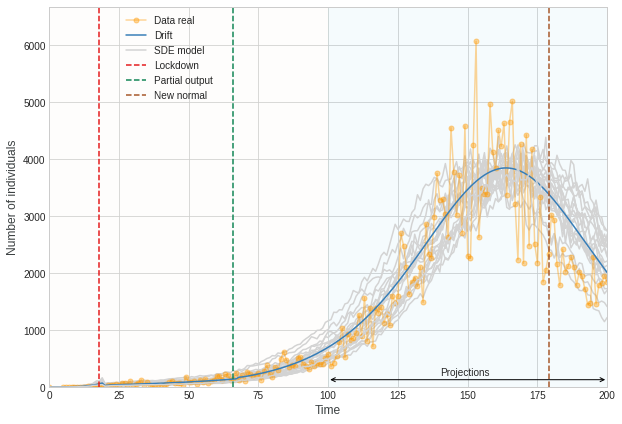

In [ ]:
SCE2IQHRD_MG.plot1('NI')

Infectados acumulados


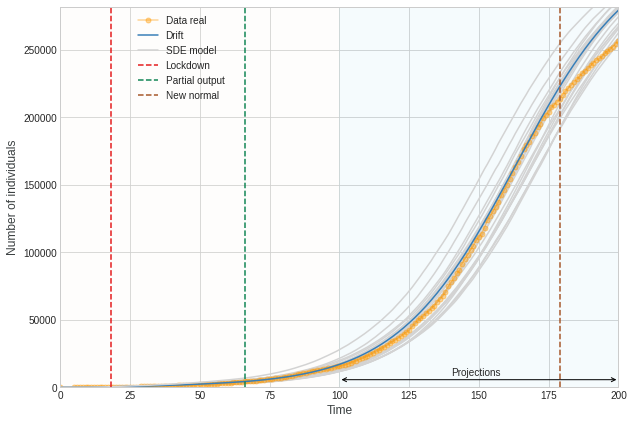

In [ ]:
SCE2IQHRD_MG.plot2('CI')

Recuperados Acumulados 

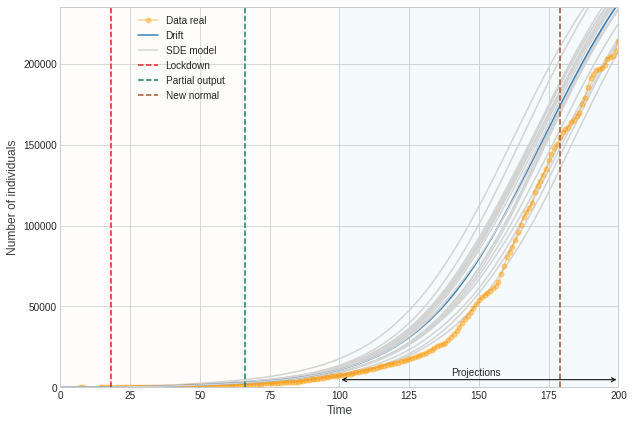

In [ ]:
SCE2IQHRD_MG.plot2('R')

Muertes acumuladas

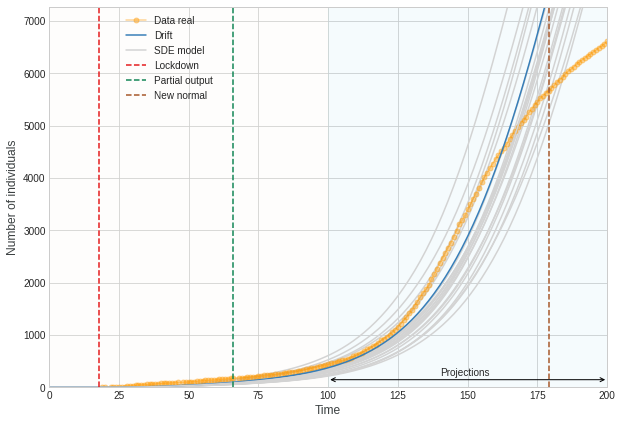

In [ ]:
SCE2IQHRD_MG.plot2('D')

Asintomaticos

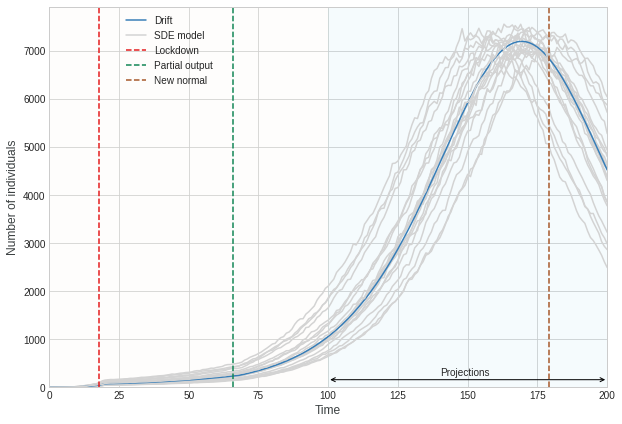

In [ ]:
SCE2IQHRD_MG.plot3('IA')

Sintomaticos

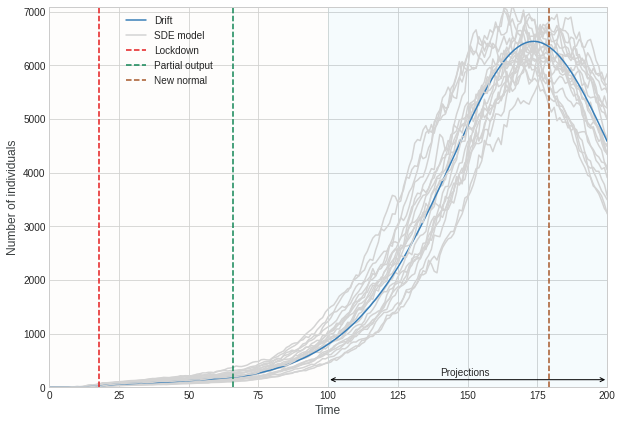

In [ ]:
SCE2IQHRD_MG.plot3('IS')

Hospotalizados

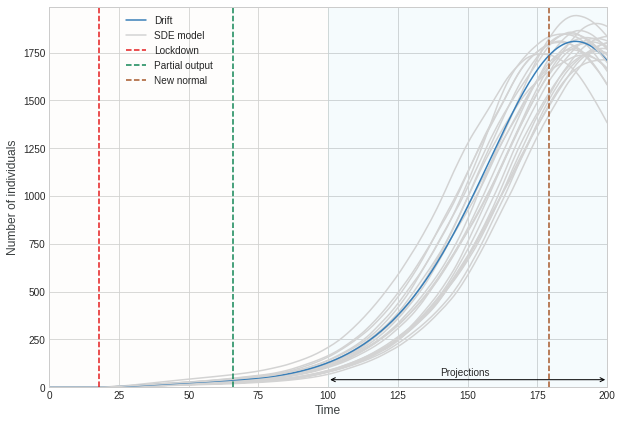

In [ ]:
SCE2IQHRD_MG.plot3('H')

Susceptibles

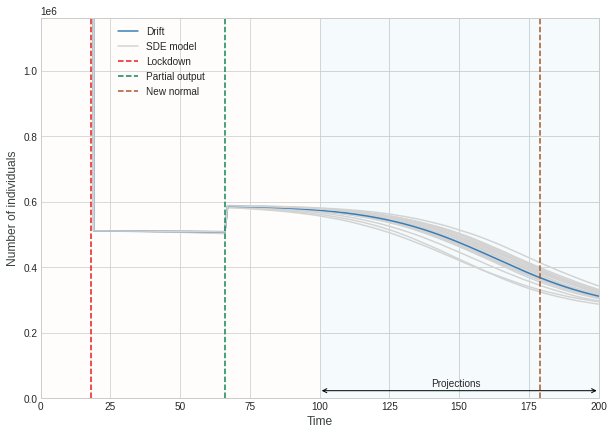

In [ ]:
SCE2IQHRD_MG.plot3('S')

## Medidas para evaluar modelos


In [ ]:
y_pred = SCE2IQHRD_MG.data_detm_y[101:]
y_true = DATACOVID19_BOG_DAYS200_NI[DATACOVID19_BOG_DAYS200_NI['Dia'] > 100]['Nuevos infectados']
round(mean_squared_log_error(y_true, y_pred), 3)

0.09

In [ ]:
y_true = DATACOVID19_BOG_DAYS200_NI[DATACOVID19_BOG_DAYS200_NI['Dia'] > 100]['Infectados acumulados']
y_pred = SCE2IQHRD.deterministic_structure()[SCE2IQHRD.deterministic_structure()['Time'] > 100]['CI']
round(mean_squared_log_error(y_true, y_pred), 3)

0.005

In [ ]:
y_true = DATACOVID19_BOG_DAYS200_NR[DATACOVID19_BOG_DAYS200_NR['Dia'] > 100]['Recuperados acumulados']
y_pred = SCE2IQHRD.deterministic_structure()[SCE2IQHRD.deterministic_structure()['Time'] > 100]['R']
round(mean_squared_log_error(y_true, y_pred), 3)

0.157

In [ ]:
y_true = DATACOVID19_BOG_DAYS200_ND[DATACOVID19_BOG_DAYS200_ND['Dia'] > 100]['Muertes acumuladas']
y_pred = SCE2IQHRD.deterministic_structure()[SCE2IQHRD.deterministic_structure()['Time'] > 100]['D']
round(mean_squared_log_error(y_true, y_pred), 3)

0.062